# MTA Project MVP

## 1. Goals

The purpose of this project is to track how subway usage changes with weather patterns.

In this situation, we are working with a clothing retailer who wants to plan pop-up events and flash sales around busy and pleasant weather days.  In particular, we will be answering the following question:

### Q. What days are historically busy and pleasant in NYC?

We want to help the retailer pick a few days over the next few months that will maximize their exposure and minimize the chance of poor weather. 


## 2. Initial Data Cleaning Approach and Exploratory Findings

In order to solve this problem, we will look at two data sets: 
* NYC MTA turnstile data
* NYC weather history

We will be examining the data based on the months of
* August
* September
* October

## 2a. NYC MTA Turnstile data

These data files are from the New York Subway.  It tracks the hourly entries and exist to turnstiles by day in the subway system.  

source: http://web.mta.info/developers/turnstile.html

Our first step will be to download the data from the website

In [2]:
import wget

# Set the url
url_template = 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_%s.txt'

# I've listed the set of files that we need to cover the span of Aug 2017 - Oct 2017
for date in ['160806','160813','160820','160827','160903','160910','160917','160924','161001','161008','161015','161022','161029']:

    # build the url
    url = url_template % date
    
    # get the file
    wget.download(url, './data/')
    print(date, 'file downloaded')

URLError: <urlopen error [Errno 8] nodename nor servname provided, or not known>

With the data downloaded, we can import each data file into a python.  We want to begin organizing this turnstile data so that we can analyze the total number of passengers that pass through a turnstile each day.  

The beginning data structure will be as follows:

key: turnstile ID

value: [[timestamp], [timestamp], [timestamp] .... ]]

Let's create a function to read in a MTA data file, and return the above structure

In [63]:
import csv
from collections import defaultdict

def read_csv(file):
    """
        Accepts an MTA turnstile data file, parses each line, and returns an 
        organized dictionary representing a list of timestamps (value) for each
        turnstile id (key)
    """
    
    # create our empty dictionary
    # defaultdict allows us to return an empty list for indicies that do not yet exist
    data = defaultdict(list)
    
    # loop through the input file
    with open(file, 'r') as csv_file:

        reader = csv.reader(csv_file)

        # update user what we are doing
        print('Reading {} ...'.format(file))

        # for each row in the file
        for i, row in enumerate(reader):

            # we know that the first row is headers, so we skip it
            if i != 0: 
                
                # create turnstile id
                ts_id = tuple(row[:5])
                
                # create timestamp data
                ts_timestamp = row[5:]
                
                # add value to dictionary
                data[ts_id].append(ts_timestamp)
    
    return data

Now we can import our data - calling the prior read_csv function to do so.  We will be storing the results into a list of dictionaries.

In [64]:
# create the list of the files we are going to use
filenames = [
    './data/turnstile_160806.txt',
    './data/turnstile_160813.txt',
    './data/turnstile_160820.txt',
    './data/turnstile_160827.txt',
    './data/turnstile_160903.txt',
    './data/turnstile_160910.txt',
    './data/turnstile_160917.txt',
    './data/turnstile_160924.txt',
    './data/turnstile_161001.txt',
    './data/turnstile_161008.txt',
    './data/turnstile_161015.txt',
    './data/turnstile_161022.txt',    
    './data/turnstile_161029.txt'
]

# import the data into raw_data
raw_data = [read_csv(f) for f in filenames]  

Reading ./data/turnstile_160806.txt ...
Reading ./data/turnstile_160813.txt ...
Reading ./data/turnstile_160820.txt ...
Reading ./data/turnstile_160827.txt ...
Reading ./data/turnstile_160903.txt ...
Reading ./data/turnstile_160910.txt ...
Reading ./data/turnstile_160917.txt ...
Reading ./data/turnstile_160924.txt ...
Reading ./data/turnstile_161001.txt ...
Reading ./data/turnstile_161008.txt ...
Reading ./data/turnstile_161015.txt ...
Reading ./data/turnstile_161022.txt ...
Reading ./data/turnstile_161029.txt ...


In [65]:
# Take a sneak peak at our data so far
sample_data = list(raw_data[0].items())[:2]
print(sample_data)

[(('A002', 'R051', '02-00-00', '59 ST', 'NQR456'), [['BMT', '07/30/2016', '00:00:00', 'REGULAR', '0005760764', '0001953626                                             '], ['BMT', '07/30/2016', '04:00:00', 'REGULAR', '0005760814', '0001953637                                             '], ['BMT', '07/30/2016', '08:00:00', 'REGULAR', '0005760842', '0001953674                                             '], ['BMT', '07/30/2016', '12:00:00', 'REGULAR', '0005760971', '0001953783                                             '], ['BMT', '07/30/2016', '16:00:00', 'REGULAR', '0005761196', '0001953844                                             '], ['BMT', '07/30/2016', '20:00:00', 'REGULAR', '0005761524', '0001953886                                             '], ['BMT', '07/31/2016', '00:00:00', 'REGULAR', '0005761691', '0001953917                                             '], ['BMT', '07/31/2016', '04:00:00', 'REGULAR', '0005761733', '0001953925                                             

At the moment, we have the entire MTA dataset loaded.  We are only interested in the timestamp and cumulative passenger count at the turnstile.  We can manipulate the current data to zone in on only the data we want to look at - and turn the timestamp into an actual datetime object.  

The data structure we are trying to achieve is as follows: 

{turnstile ID:

    [ 
    
        [timestamp, passenger counts],
        
        [timestamp, passenger counts],
        
        [timestamp, passenger counts],
      
        ....
         
    ]
    
},
{turnstile ID:

    [
    
        [timestamp, passenger counts],
        
        [timestamp, passenger counts],
        
        [timestamp, passenger counts],
        
         ....
         
    ]
    
),

...


We will create a function to do this data manipulation: mta_create_timestamp



In [68]:
from dateutil.parser import parse
from datetime import datetime
from collections import defaultdict

def mta_create_timestamp(data):
    """
        Accepts a dictionary structure of MTA turnstile data, with the turnstile ID (key) and related 
        time stamped entrires (value).
        
        Manipulates the data to create an actual timestamp for each entry and cumulative passengers. 
    """
    
    # initialize a dictionary to store results
    ts_timestamps = defaultdict(list)
    
    # iterate over the turnstile data
    for i, (turnstile, row_data) in enumerate(data.items()):
        
        # print out our status
        if i % 100 == 0:
            print('Processing turnstile {}...'.format(turnstile))

        # for each time entry, convert to a timestamp and retain cumulative entires
        for division, datestr, timestr, event, cum_entries, cum_exits in row_data:
            
            # create timestamp
            timestamp = parse(datestr + ' ' + timestr)
            
            # save data back to the dictionary
            ts_timestamps[turnstile].append([timestamp, int(cum_entries)])
    
    return ts_timestamps
            



In [71]:
# create timestamps
timestamp_data = [mta_create_timestamp(raw_data[i]) for i in range(len(raw_data))]


Processing turnstile ('A002', 'R051', '02-00-00', '59 ST', 'NQR456')...
Processing turnstile ('A030', 'R083', '01-06-00', '23 ST', 'NR')...
Processing turnstile ('A049', 'R088', '02-01-01', 'CORTLANDT ST', 'R')...
Processing turnstile ('A084', 'R125', '01-00-03', 'BROAD ST', 'JZ')...
Processing turnstile ('B024', 'R211', '00-00-03', 'KINGS HWY', 'BQ')...
Processing turnstile ('C012', 'R258', '01-03-01', '4AV-9 ST', 'DFGMNR')...
Processing turnstile ('E001', 'R368', '00-00-00', '9 AV', 'D')...
Processing turnstile ('H007', 'R248', '00-00-00', '1 AV', 'L')...
Processing turnstile ('H039', 'R375', '00-00-01', 'NEW LOTS', 'L')...
Processing turnstile ('J030', 'R005', '00-00-00', '85 ST-FOREST PK', 'J')...
Processing turnstile ('N012', 'R035', '01-06-03', '168 ST', 'AC1')...
Processing turnstile ('N049', 'R084', '01-00-00', '59 ST COLUMBUS', 'ABCD1')...
Processing turnstile ('N067', 'R012', '00-03-02', '34 ST-PENN STA', 'ACE')...
Processing turnstile ('N087', 'R282', '01-06-01', 'SPRING ST'

In [73]:
# Take a sneak peak at our data so far
sample_data= list(timestamp_data[0].items())[:1]
print(sample_data)

[(('A002', 'R051', '02-00-00', '59 ST', 'NQR456'), [[datetime.datetime(2016, 7, 30, 0, 0), 5760764], [datetime.datetime(2016, 7, 30, 4, 0), 5760814], [datetime.datetime(2016, 7, 30, 8, 0), 5760842], [datetime.datetime(2016, 7, 30, 12, 0), 5760971], [datetime.datetime(2016, 7, 30, 16, 0), 5761196], [datetime.datetime(2016, 7, 30, 20, 0), 5761524], [datetime.datetime(2016, 7, 31, 0, 0), 5761691], [datetime.datetime(2016, 7, 31, 4, 0), 5761733], [datetime.datetime(2016, 7, 31, 8, 0), 5761748], [datetime.datetime(2016, 7, 31, 12, 0), 5761841], [datetime.datetime(2016, 7, 31, 16, 0), 5762029], [datetime.datetime(2016, 7, 31, 20, 0), 5762275], [datetime.datetime(2016, 8, 1, 0, 0), 5762406], [datetime.datetime(2016, 8, 1, 4, 0), 5762419], [datetime.datetime(2016, 8, 1, 8, 0), 5762463], [datetime.datetime(2016, 8, 1, 12, 0), 5762608], [datetime.datetime(2016, 8, 1, 16, 0), 5762961], [datetime.datetime(2016, 8, 1, 20, 0), 5763874], [datetime.datetime(2016, 8, 2, 0, 0), 5764095], [datetime.datet

We now have a list of dictionaries - each representing a one week span at MTA.  We want to combine all dictionaries so that we have a complete listing of passengers for each turnstile from August to October.   

We can do this using the combine_weekly_dictionaries function below

In [74]:
def combine_weekly_dictionaries(data):
    """
        Accepts a list of dictionaries (each representing a two week span in MTA turnstile data), combines
        each dictionary based on turnstile id, and returns the combined dictionary for consumption.
    """

    # declare our variable to hold all data 
    combined = defaultdict(list)
    
    # loop through each dictionary 
    for d in data:
        
        # for each dictionary, loop through k, v pairs (turnstile, timestamps)
        for turnstile, time_series in d.items():
            
            # add the timeseries to the turnstile id
            combined[turnstile] += time_series
            
    return combined

In [75]:
# retrieves the data
all_timestamp_data = combine_weekly_dictionaries(timestamp_data)


In [76]:
# Take a sneak peak at our data so far
list(all_timestamp_data.items())[:2]


[(('A002', 'R051', '02-00-00', '59 ST', 'NQR456'),
  [[datetime.datetime(2016, 7, 30, 0, 0), 5760764],
   [datetime.datetime(2016, 7, 30, 4, 0), 5760814],
   [datetime.datetime(2016, 7, 30, 8, 0), 5760842],
   [datetime.datetime(2016, 7, 30, 12, 0), 5760971],
   [datetime.datetime(2016, 7, 30, 16, 0), 5761196],
   [datetime.datetime(2016, 7, 30, 20, 0), 5761524],
   [datetime.datetime(2016, 7, 31, 0, 0), 5761691],
   [datetime.datetime(2016, 7, 31, 4, 0), 5761733],
   [datetime.datetime(2016, 7, 31, 8, 0), 5761748],
   [datetime.datetime(2016, 7, 31, 12, 0), 5761841],
   [datetime.datetime(2016, 7, 31, 16, 0), 5762029],
   [datetime.datetime(2016, 7, 31, 20, 0), 5762275],
   [datetime.datetime(2016, 8, 1, 0, 0), 5762406],
   [datetime.datetime(2016, 8, 1, 4, 0), 5762419],
   [datetime.datetime(2016, 8, 1, 8, 0), 5762463],
   [datetime.datetime(2016, 8, 1, 12, 0), 5762608],
   [datetime.datetime(2016, 8, 1, 16, 0), 5762961],
   [datetime.datetime(2016, 8, 1, 20, 0), 5763874],
   [dateti

Great - we now have a single dictionary where we have the turnstile ID (Key) and the timestamped cumulative passenger entry data (value).

Now we want to summarize this hourly data into daily.  We can do that using our calculate_daily_summary below.



In [77]:
def validate_daily_total(total):
    """
        Takes a total number of passengers that has visited a turnstile over the 
        period of 1 day and validates that its within a predefined limit.  
        For now, the limit is to ensure the total is greater than 0, and less than 10,000 passengers
    """
    if total == None:
        return True
    else:
        return 10000 > total >= 0

In [78]:
from itertools import groupby
from collections import defaultdict

def calculate_daily_summary(data):
    """
        Takes an array of hourly turnstile entries spread across multiple days and summarizes
        the data at a daily level. 
    """

    # create a varaible to hold our summary per day
    turnstile_daily_summary = []
    
    # create a variable to store the previous day's passenger count
    passenger_count_prevday = None
    
    # group the turnstile entries by date
    for current_date, daily_entries in groupby(data, lambda x: x[0].date()):
        
        # find the maximum for the day
        passenger_count_curday = max([count for time, count in daily_entries])

        # calculate total for the day
        if passenger_count_prevday == None:
            daily_total = None;
        else:
            daily_total = passenger_count_curday - passenger_count_prevday
            
        # check to ensure date count isn't crazy insane
        if validate_daily_total(daily_total):
            turnstile_daily_summary.append([current_date, daily_total])
        else:
            print('Warning: Date total appears to be incorrect for {} total: {}'.format(current_date, daily_total))
            turnstile_daily_summary.append([current_date, None])
        
        # update the date counter
        passenger_count_prevday = passenger_count_curday
    
    return turnstile_daily_summary
                

In [79]:
# create our new summary variable
daily_data = defaultdict(list)

# loop through the dictionary and summarize
for i, (turnstile, hourly_entries) in enumerate(all_timestamp_data.items()):
    print('===   Processing {}   ==='.format(turnstile))
    daily_data[turnstile] = calculate_daily_summary(hourly_entries)



===   Processing ('A002', 'R051', '02-00-00', '59 ST', 'NQR456')   ===
===   Processing ('A002', 'R051', '02-00-01', '59 ST', 'NQR456')   ===
===   Processing ('A002', 'R051', '02-03-00', '59 ST', 'NQR456')   ===
===   Processing ('A002', 'R051', '02-03-01', '59 ST', 'NQR456')   ===
===   Processing ('A002', 'R051', '02-03-02', '59 ST', 'NQR456')   ===
===   Processing ('A002', 'R051', '02-03-03', '59 ST', 'NQR456')   ===
===   Processing ('A002', 'R051', '02-03-04', '59 ST', 'NQR456')   ===
===   Processing ('A002', 'R051', '02-03-05', '59 ST', 'NQR456')   ===
===   Processing ('A002', 'R051', '02-03-06', '59 ST', 'NQR456')   ===
===   Processing ('A002', 'R051', '02-05-00', '59 ST', 'NQR456')   ===
===   Processing ('A002', 'R051', '02-05-01', '59 ST', 'NQR456')   ===
===   Processing ('A002', 'R051', '02-06-00', '59 ST', 'NQR456')   ===
===   Processing ('A006', 'R079', '00-00-00', '5 AV/59 ST', 'NQR')   ===
===   Processing ('A006', 'R079', '00-00-01', '5 AV/59 ST', 'NQR')   ===
==

It's interesting to note that there are issues with the data here - we see several turnstiles change count between days (as noted in the code output above).

It would be worth while to speak with someone more knowledgable about the data to determine why this happens, and if there is a way to account for the oddities in the data.

In [80]:
# Take a sneak peak at our data so far
sample_data = list(daily_data.items())[:2]
print(sample_data)


[(('A002', 'R051', '02-00-00', '59 ST', 'NQR456'), [[datetime.date(2016, 7, 30), None], [datetime.date(2016, 7, 31), 751], [datetime.date(2016, 8, 1), 1599], [datetime.date(2016, 8, 2), 1668], [datetime.date(2016, 8, 3), 1689], [datetime.date(2016, 8, 4), 1695], [datetime.date(2016, 8, 5), 1628], [datetime.date(2016, 8, 6), 979], [datetime.date(2016, 8, 7), 740], [datetime.date(2016, 8, 8), 1470], [datetime.date(2016, 8, 9), 1679], [datetime.date(2016, 8, 10), 1693], [datetime.date(2016, 8, 11), 1607], [datetime.date(2016, 8, 12), 1680], [datetime.date(2016, 8, 13), 947], [datetime.date(2016, 8, 14), 743], [datetime.date(2016, 8, 15), 1488], [datetime.date(2016, 8, 16), 1588], [datetime.date(2016, 8, 17), 1579], [datetime.date(2016, 8, 18), 1653], [datetime.date(2016, 8, 19), 1622], [datetime.date(2016, 8, 20), 904], [datetime.date(2016, 8, 21), 722], [datetime.date(2016, 8, 22), 1504], [datetime.date(2016, 8, 23), 1675], [datetime.date(2016, 8, 24), 1618], [datetime.date(2016, 8, 25),

We now have a daily summary for the number of passengers that visit each turnstile in a station.  A station may have many turnstiles - in order for us to be able to do an analysis, we want to know how many passengers pass through a station.  Let's get the daily summary per station using the group_by_station function below. 

In [84]:
def get_station_name(turnstile_data):
    """
        Given turnstile data in the form (turnstile, timeseries), 
        unpack the data and return the identifier defined by station
    """
    # unpack the data
    turnstile, timeseries = turnstile_data
    control_area, unit, device_id, station, line = turnstile

    return (tuple([station, line]))


In [85]:
from collections import Counter
import operator

def group_by_station(data):
    """
        Given data grouped by turnstile, summarize daily passenger counts
        by station.
    """

    mta_data_by_station = {}

    # sort our dictionary first - this ensures we groupby correctly
    data_sorted = sorted(data.items(), key=operator.itemgetter(0))
    
    # loop through data by station
    for station, data in groupby(data_sorted, get_station_name):   
            
        # initalize counter
        daily_counter = Counter()
        
        # loop through each turnstile in the station
        for turnstile, timeseries in data:
                    
            # Unpack the timeseries - begin to summarize by station
            for datestamp, passenger_count in timeseries:           
                
                # ensure we only add integer values
                if passenger_count is not None:
                    daily_counter[datestamp] += passenger_count
                           
        # store the count per station
        mta_data_by_station[station] = sorted(daily_counter.items())
            
    return mta_data_by_station

In [87]:
cleaned_data = group_by_station(daily_data)


We now have clean data - a summary of the number of passengers that enter each station, for the time range of August to September.  I wonder what this looks like in a graph ...


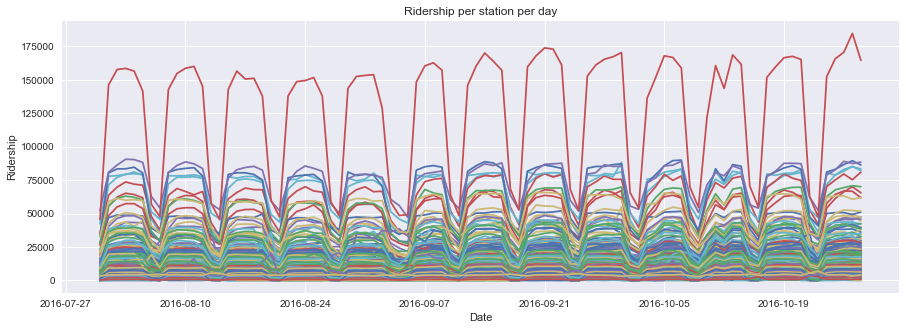

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,5))

for station, time_entries in cleaned_data.items():           

    days, counts = zip(*time_entries)
    plt.plot(days, counts)

plt.title('Ridership per station per day')
plt.xlabel('Date')
plt.ylabel('Ridership')

plt.show()


What does ridership look like per day?

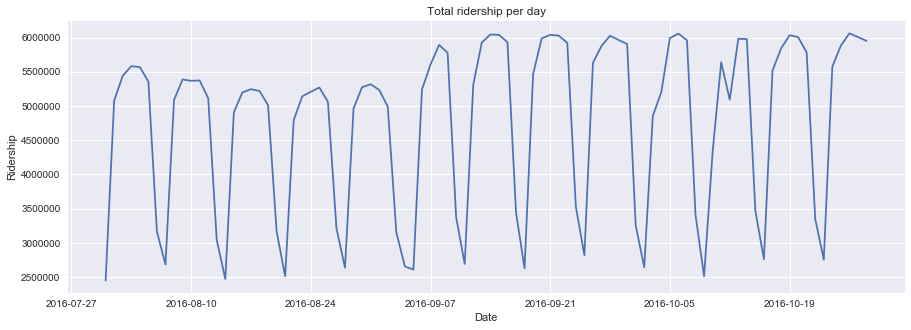

In [89]:
from collections import Counter

daily_total = Counter()

for station, time_entries in cleaned_data.items():
    
    for day, count in time_entries:
        daily_total[day]+= count

days = list(daily_total.keys())
counts = list(daily_total.values())

plt.figure(figsize=(15,5))
plt.plot(days, counts)

plt.title('Total ridership per day')
plt.ylabel('Ridership')
plt.xlabel('Date')
plt.show()

What are the top 15 stations?

In [91]:
def find_station_total(data):

    station_totals = Counter()
    
    for station, time_entries in data.items():
        
        for date, ridership in time_entries:
            station_totals[station] += ridership
    
    return station_totals


In [92]:
st = find_station_total(cleaned_data)
sorted_st = sorted(st.items(), key=operator.itemgetter(1), reverse=True)

for x in range(15):
    print(sorted_st[x])

(('GRD CNTRL-42 ST', '4567S'), 11446228)
(('TIMES SQ-42 ST', '1237ACENQRS'), 6761915)
(('42 ST-PORT AUTH', 'ACENQRS1237'), 6293570)
(('34 ST-PENN STA', 'ACE'), 6260369)
(('34 ST-HERALD SQ', 'BDFMNQR'), 5882429)
(('14 ST-UNION SQ', 'LNQR456'), 5712669)
(('86 ST', '456'), 4930670)
(('FLUSHING-MAIN', '7'), 4915498)
(('59 ST COLUMBUS', 'ABCD1'), 4553229)
(('47-50 STS ROCK', 'BDFM'), 4373001)
(('JKSN HT-ROOSVLT', 'EFMR7'), 4010089)
(('59 ST', '456NQR'), 3815893)
(('W 4 ST-WASH SQ', 'ABCDEFM'), 3436941)
(('42 ST-BRYANT PK', 'BDFM7'), 3265150)
(('72 ST', '123'), 3132088)


In [171]:
for (s, line), count in sorted_st:
    print(s)
    
for (s, line), count in sorted_st:
    print(line)
    
        

GRD CNTRL-42 ST
TIMES SQ-42 ST
42 ST-PORT AUTH
34 ST-PENN STA
34 ST-HERALD SQ
14 ST-UNION SQ
86 ST
FLUSHING-MAIN
59 ST COLUMBUS
47-50 STS ROCK
JKSN HT-ROOSVLT
59 ST
W 4 ST-WASH SQ
42 ST-BRYANT PK
72 ST
JAY ST-METROTEC
96 ST
JAMAICA CENTER
LEXINGTON AV/53
14 ST-UNION SQ
77 ST
BOROUGH HALL
68ST-HUNTER CO
BOWLING GREEN
CHAMBERS ST
125 ST
BEDFORD AV
33 ST
CROWN HTS-UTICA
49 ST
FOREST HILLS 71
8 AV
23 ST
KEW GARDENS
23 ST
SUTPHIN-ARCHER
145 ST
50 ST
125 ST
GRAND ST
FULTON ST
96 ST
23 ST
WALL ST
57 ST-7 AV
23 ST
1 AV
JUNCTION BLVD
28 ST
66 ST-LINCOLN
14 ST
5 AV/53 ST
WOODHAVEN BLVD
CHAMBERS ST
JAMAICA 179 ST
51 ST
103 ST-CORONA
50 ST
3 AV-149 ST
BROOKLYN BRIDGE
B'WAY-LAFAYETTE
JOURNAL SQUARE
MYRTLE-WYCKOFF
ATL AV-BARCLAY
5 AV/59 ST
WALL ST
8 ST-NYU
KINGS HWY
THIRTY THIRD ST
86 ST
GROVE STREET
14 ST
FLATBUSH AV-B.C
NOSTRAND AV
14 ST
PAVONIA/NEWPORT
DEKALB AV
CONEY IS-STILLW
34 ST-PENN STA
61 ST WOODSIDE
CANAL ST
2 AV
90 ST-ELMHURST
BLEECKER ST
CHURCH AV
CORTLANDT ST
59 ST
PRINCE ST
DELANCEY/E

Let's see the totals in a graph

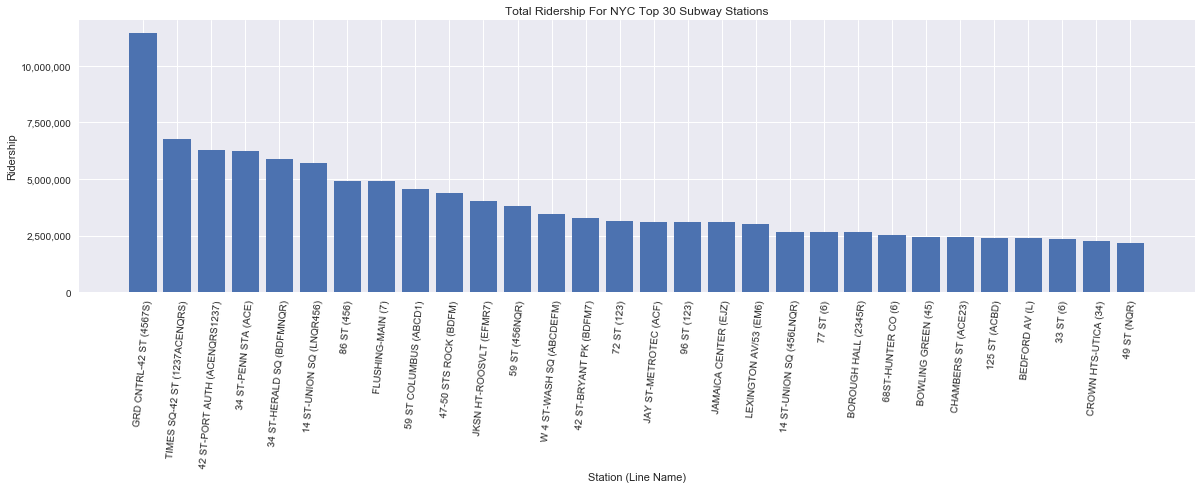

In [167]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

station_names = ['{} ({})'.format(station, line) for (station, line), count in sorted_st]
station_names = station_names[:30]
ridership = [count for (station, line), count in sorted_st]
ridership = ridership[:30]

xaxis = np.arange(len(station_names))

# Plot the graph
fig, ax = plt.subplots(figsize=(20,5))
plt.bar(xaxis, ridership)

# set x ticks
plt.xticks(np.arange(min(xaxis), max(xaxis)+1, 1), station_names, rotation=85)

# set y ticks
start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(start, end, 2500000))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

# set labels
plt.title('Total Ridership For NYC Top 30 Subway Stations')
plt.ylabel('Ridership')
plt.xlabel('Station (Line Name)')
plt.show()

If we wanted to know ridership per day of the week - what would that look like? 

In [198]:
from collections import defaultdict

def group_by_day_of_week(data):
       
    day_of_week_total = defaultdict(list)
    day_of_week_avg = {}

    for day, count in daily_total.items():   
        day_of_week_total[day.weekday()].append(count)
    
    for i in range(7):
        day_of_week_avg[i] = sum(day_of_week_total[i]) / len(day_of_week_total[i])
        #print(sum(day_of_week_total[i]))
        #print(len(day_of_week_total[i]))
        #print(day_of_week_avg[i])

    return day_of_week_avg


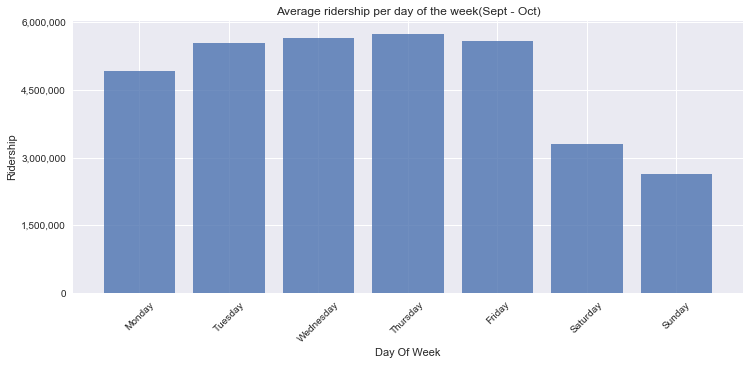

In [222]:
day_of_week_totals = group_by_day_of_week(daily_total)   

x_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
days = list(day_of_week_totals.keys())
counts = list(day_of_week_totals.values())

# Plot the graph
fig, ax = plt.subplots(figsize=(12,5))
plt.bar(days, counts, alpha=0.8)

# set x ticks
#ax.set_xticklabels(x_labels)
plt.xticks(np.arange(min(days), max(days)+1, 1), x_labels, rotation=45)

# set y ticks
start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(start, end, 1500000))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

# add labels
plt.title('Average ridership per day of the week (Sept - Oct)')
plt.ylabel('Ridership')
plt.xlabel('Day Of Week')
plt.show()

## 2b. NYC NOAA weather data

These data files are from NOAA Online Weather, and are taken from the weather station located in Central Park, NY.  It contains daily weather data (max, min, average temperature (F)) as well as precipitation, snowfall and snow depth for all days from August to September 2014-2016.  

source: http://w2.weather.gov/climate/xmacis.php?wfo=okx
    

In [94]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# import the weather data into a dataframe
temp = pd.read_csv('./Data/nyc_temperature.csv', parse_dates=['date'], index_col=0)

Let's explore the dataset

In [95]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 276 entries, 2014-08-01 to 2016-10-31
Data columns (total 6 columns):
temp_max         276 non-null int64
temp_min         276 non-null int64
temp_avg         276 non-null float64
precipitation    276 non-null object
new_snow         276 non-null int64
snow_depth       276 non-null int64
dtypes: float64(1), int64(4), object(1)
memory usage: 15.1+ KB


In [96]:
temp.describe()

,temp_max,temp_min,temp_avg,new_snow,snow_depth
count,276.000000,276.000000,276.000000,276.0,276.0
mean,76.851449,62.000000,69.425725,0.0,0.0
std,10.660873,9.623456,9.949642,0.0,0.0
min,50.000000,35.000000,44.000000,0.0,0.0
25%,69.000000,55.000000,62.500000,0.0,0.0
50%,79.000000,63.500000,71.500000,0.0,0.0
75%,86.000000,69.250000,77.500000,0.0,0.0
max,97.000000,81.000000,88.500000,0.0,0.0


In [97]:
temp.head()

,temp_max,temp_min,temp_avg,precipitation,new_snow,snow_depth
date,,,,,,
2014-08-01,84,71,77.5,0,0,0
2014-08-02,74,63,68.5,0.41,0,0
2014-08-03,76,66,71.0,0.07,0,0
2014-08-04,84,70,77.0,0,0,0
2014-08-05,90,71,80.5,0,0,0


The **precipitation** column denotes if any precipitation occurred on the given day.  A value of 'T' denotes that trace amounts of precipitation were found.  

This mixed valued column needs to be modified so that we can perform proper filtering.  We are looking for 'pleasant' days for our retailer - and so we will convert the precipitation column into binary value defining whether or not precipitation was observed.  A trace amount will be considered as 'precipitation occurred'

We will make this mapping in the following code snippets.

In [98]:
def precip_check(t):
    """
        Validates a percipitation amount to verify if percipitation was observed
        for a given day.
        
        Returns True for any value greater than 0, or in cases where trace amounts were
        observed. 
    """
    try: 
        if float(t) > 0: 
            return True
        else:
            return False
    except:
            return True
  

In [99]:
# create a new column named 'precip', which will be a boolean value to identify 
# whether precipitation was observed on the given day
temp['precip'] = temp.precipitation.apply(precip_check)

In [100]:
# lets view the new data
temp

,temp_max,temp_min,temp_avg,precipitation,new_snow,snow_depth,precip
date,,,,,,,
2014-08-01,84,71,77.5,0,0,0,False
2014-08-02,74,63,68.5,0.41,0,0,True
2014-08-03,76,66,71.0,0.07,0,0,True
2014-08-04,84,70,77.0,0,0,0,False
2014-08-05,90,71,80.5,0,0,0,False
2014-08-06,83,70,76.5,0,0,0,False
2014-08-07,83,66,74.5,0,0,0,False
2014-08-08,83,65,74.0,0,0,0,False
2014-08-09,87,66,76.5,0,0,0,False


Let's separate the data into month/day andthen have a look at the data

In [101]:
# create a month_day column that can be used for plotting
temp['month_day'] = [d.strftime('%b %d') for d in temp.index]
temp.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 276 entries, 2014-08-01 to 2016-10-31
Data columns (total 8 columns):
temp_max         276 non-null int64
temp_min         276 non-null int64
temp_avg         276 non-null float64
precipitation    276 non-null object
new_snow         276 non-null int64
snow_depth       276 non-null int64
precip           276 non-null bool
month_day        276 non-null object
dtypes: bool(1), float64(1), int64(4), object(2)
memory usage: 17.5+ KB


In [220]:
from datetime import datetime
from matplotlib import dates

fig, ax = plt.subplots(figsize=(15,8)) 

hfmt = dates.DateFormatter('%b %d')
ax.xaxis.set_major_formatter(hfmt)
ax.xaxis.set_major_locator(dates.MonthLocator())
plt.title('NYC Daily Average Temperature')
plt.ylabel('Temp (F)')
plt.xlabel('Date')

for year in ['2014', '2015', '2016']:
    df = temp[year]
    
    x = dates.date2num([datetime.strptime(d, '%b %d') for d in df['month_day']])
    y = df['temp_avg']
    
    plt.plot(x, y, alpha=0.5, label = year)

plt.legend(loc='best')
plt.show()


NameError: name 'temp' is not defined

How many days do we actually have each year where the weather is pleasant? We define a pleasant day as
* avg temp >= 68F
* no precipitation

In [103]:
# filter days to only have pleasant weather
temp_mask = temp['temp_avg'] >= 70
precip_mask = temp['precip'] == False

pleasant_days = temp[temp_mask & precip_mask]

Let's plot the results

//anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
//anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


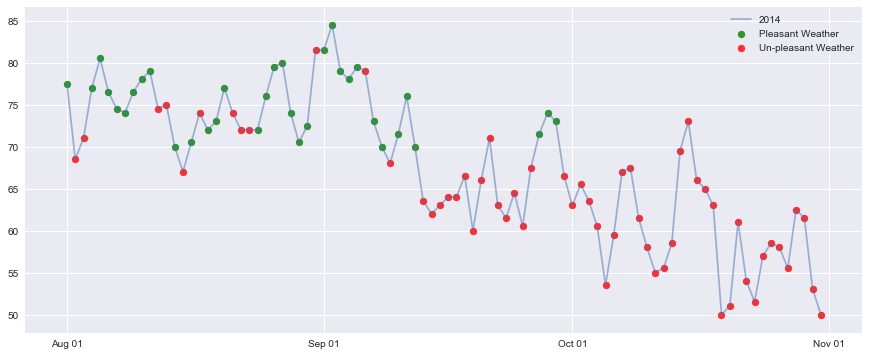

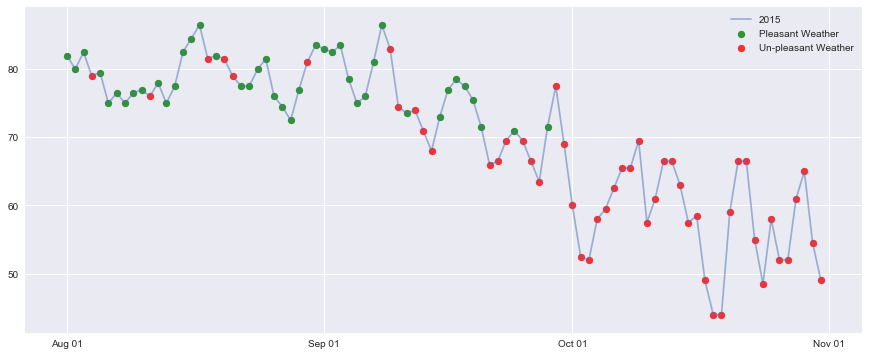

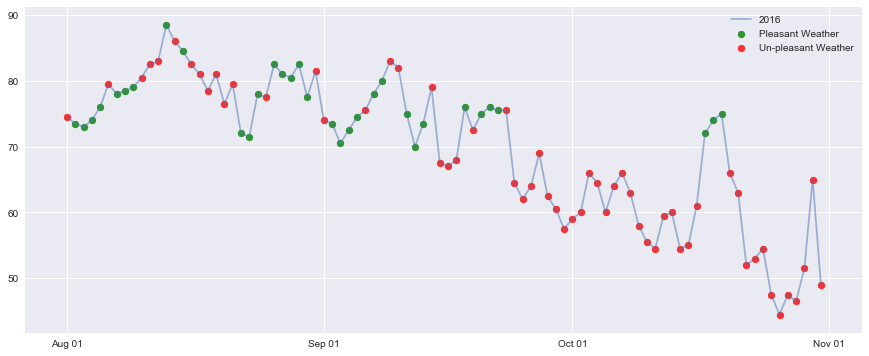

In [140]:
# Loop through our years 
for year in ['2014', '2015', '2016']:

    # setup the plot
    fig, ax = plt.subplots(figsize=(15,6)) 

    hfmt = dates.DateFormatter('%b %d')

    ax.xaxis.set_major_formatter(hfmt)
    ax.xaxis.set_major_locator(dates.MonthLocator())

    # find the plot for the year
    x = dates.date2num([datetime.strptime(d, '%b %d') for d in temp[year].month_day])
    y = temp[year].temp_avg

    # create the plot
    plt.plot(x, y, alpha=0.5, label = year)

    # find the plot for pleasant weather
    df_year = temp[year]
    pleasant_days = df_year[temp_mask & precip_mask]
    unpleasant_days = df_year[~temp_mask | ~precip_mask]
    
    x_p = dates.date2num([datetime.strptime(d, '%b %d') for d in pleasant_days['month_day']])
    y_p = pleasant_days['temp_avg']
    x_up = dates.date2num([datetime.strptime(d, '%b %d') for d in unpleasant_days['month_day']])
    y_up = unpleasant_days['temp_avg']

    # create the plot
    plt.scatter(x_p, y_p, label = 'Pleasant Weather', color='g', alpha=0.8)
    plt.scatter(x_up, y_up, label = 'Un-pleasant Weather', color='r', alpha=0.8)
   
    plt.legend(loc='best')
    plt.show()




We have identified what days are pleasant in our analysis window.  How can we get an idea of what days are historically pleasant (meaning, over the years, has the same day been consistently plesant)? 

In [105]:
# Get a list of pleasant days
pleasant_days = temp[temp_mask & precip_mask]

# create a set 
days2014 = set(list(pleasant_days['2014'].month_day))
days2015 = set(list(pleasant_days['2015'].month_day))
days2016 = set(list(pleasant_days['2016'].month_day))

common_days = set.intersection(days2014, days2015, days2016)

print(common_days)


{'Aug 28', 'Sep 02', 'Sep 03', 'Sep 04', 'Aug 26', 'Aug 08', 'Aug 27', 'Aug 24', 'Aug 09', 'Sep 07', 'Aug 29', 'Aug 05', 'Sep 08', 'Sep 05', 'Aug 07', 'Sep 11'}


What does this data look like if we show ridership levels for the pleasant days?

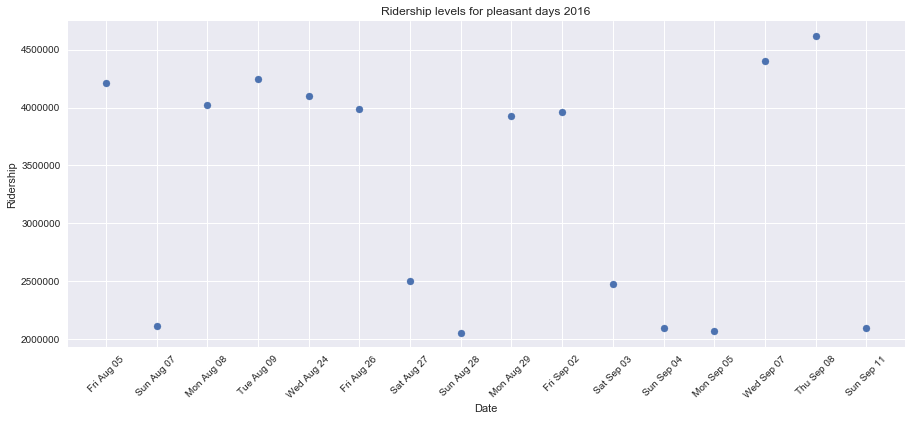

In [139]:
from collections import Counter

# define counter
daily_total = Counter()

# loop through each station
for station, time_entries in cleaned_data.items():
    
    # find the daily ridership
    for day, count in time_entries:
        
        # we only care about ridership if this day is historicaly pleasant
        if day.strftime('%b %d') in common_days:
            daily_total[day]+= count

# define our x and y axis
ridership = list(daily_total.values())
days = list(daily_total.keys())
days_axis = np.arange(len(days))
day_label=[]

# build up a list of labels for the xaxis
for d in days:
    day_label.append(d.strftime('%a %b %d'))
    
# plot ridership
fig, ax = plt.subplots(figsize=(15,6)) 
plt.scatter(days_axis, ridership)
plt.xticks(days_axis, day_label, rotation=45)
plt.ylabel('Ridership')
plt.xlabel('Date')
plt.title('Ridership levels for pleasant days 2016')

plt.show()

## 3. Initial Research Findings

There are many findings after the initial research, which I will summarize below.

### Ridership
a) There are several issues wtih data consistentcy with the turnstile data that need to be addressed in some manner:
* Turnstile ridership numbers are inconsistent for some turnstiles (sometimes higher, sometimes lower than the previous reading).  This could be a result of the turnstile internal counter mechancisms being replaced due to maintenance.  As a result, we do not have accurate ridership numbers for these turnstiles which then impact the total ridership for a station. 

b) Stations appear to be busier leading into the second half of september / october.  Possible reasons for this include: Weather (it's cold and rainy - people would rather take subway than walk), Summer has ended (Vacations end and back to school)

c) Ridership is significantly higher on weekdays verus weekends.  Targeting a weekday would result in reaching a wider audience.  

d) Ridership is affected by holidays.  Across the dataset (August to October), we observe only one holiday during the weekday - This being Columbus Day in October.  Although ridership is higher than a typical weekend, we still notice a considerable drop in ridership as a result.

### Weather
a) Weather begins to become unpleasant in later September.  We defined a pleasant day as being 70F with no rain.  We defined days having 'trace' amounts of percipitation as being unpleasant, which may not be accurate.  

b) There are additional factors that play into pleasant days - such as dew point, humidity, etc.  The dataset that we have selected did not report these additional varaibles - but it is possible to expand on this initial assement with additional variables for future analysis. 

c) In order to show some consistency of which days are pleasant, we observed weather over the course of 3 years and only selected days that wer pleasant within each of these three years.  
* Based on this assessment, we see that there are 16 potential days over our span of August to October that are defined as pleasant.



## 4. Further Research and Analysis

This was only an initial MVP analysis - further data analsis can take place to look into other factors that can affect a retailers decisions for busy & pleasant days.  Particularly: 

### Ridership
* Do we care about certain areas within the city (e.g. Knowning more information about the client, we can target specific stations based on target market)?
* Do we care about time of day to determine a busy day (e.g. Maybe we know that shoppers only venture out to stores during the lunch hour - this could impact our anlaysis of busy days)? 
* Should we look at an average daily ridership over multiple years? 
* How do we account for data that is messed up on ridership levels (e.g. where turnstile counts are not accurate)
* Can we plot the data on a map for representation?

### Weather
* Is our definition of pleasant days correct?  Do we lower the temperature from 70F (it appears that october historically dips below 70F - meaning no days from october are included in our findings)?
* Is 3 years of data considered accurate?  Should we expand to 5 years of historical data?

The above will be finalized in a formal write up for this EDA. 